In [39]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

In [40]:
import os
from PIL import Image
import torch
import cv2
import re
import numpy as np
import openai

from langchain_openai import ChatOpenAI 
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import  FAISS
from langchain_core.tools import tool
from langchain.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain
import pytz
from langchain_core.runnables import RunnableConfig

from time import monotonic
from dotenv import load_dotenv
from pprint import pprint
import os
from datasets import Dataset
from typing_extensions import TypedDict
from IPython.display import display, Image
from typing import List, TypedDict

from helper_functions import num_tokens_from_string, replace_t_with_space, replace_double_lines_with_one_line, split_into_chapters,\
analyse_metric_results, escape_quotes, text_wrap,extract_book_quotes_as_documents

In [41]:
os.environ["OPENAI_API_KEY"] = ""
groq_api_key = ""

guides_path='IICRC.pdf'

In [42]:
chapters = split_into_chapters(guides_path, start_page=89)
chapters = replace_t_with_space(chapters)
print(len(chapters))

17


In [43]:
summarization_prompt_template = """Write an extensive summary of the following, maintain headings as they're important:

{text}

SUMMARY:"""

summarization_prompt = PromptTemplate(template=summarization_prompt_template, input_variables=["text"])

In [44]:
def create_chapter_summary(chapter):
    """
    Creates a summary of a chapter using a large language model (LLM).

    Args:
        chapter: A Document object representing the chapter to summarize.

    Returns:
        A Document object containing the summary of the chapter.
    """

    chapter_txt = chapter.page_content  # Extract chapter text
    model_name = "gpt-4o"  # Specify LLM model
    llm = ChatOpenAI(temperature=0, model_name=model_name)  # Create LLM instance
    gpt_35_turbo_max_tokens = 16000  # Maximum token limit for the LLM
    verbose = False  # Set to True for more detailed output

    # Calculate number of tokens in the chapter text
    num_tokens = num_tokens_from_string(chapter_txt, model_name)

    # Choose appropriate chain type based on token count
    if num_tokens < gpt_35_turbo_max_tokens:
        chain = load_summarize_chain(llm, chain_type="stuff", prompt=summarization_prompt, verbose=verbose) 
    else:
        chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=summarization_prompt, combine_prompt=summarization_prompt, verbose=verbose)

    start_time = monotonic()  # Start timer
    doc_chapter = Document(page_content=chapter_txt)  # Create Document object for chapter
    summary = chain.invoke([doc_chapter])  # Generate summary using the chain
    print(f"Chain type: {chain.__class__.__name__}")  # Print chain type
    print(f"Run time: {monotonic() - start_time}")  # Print execution time

    summary = replace_double_lines_with_one_line(summary["output_text"])
    summary_text = "\n".join(summary)

    doc_summary = Document(page_content=summary_text, metadata=chapter.metadata)

    return doc_summary

In [45]:
preliminary_inspection_chapter = [chapters[9]]
preliminary_inspection_chapter2 = chapters[9]
preliminary_inspection_summary = create_chapter_summary(preliminary_inspection_chapter2)
preliminary_inspection_summary

Chain type: StuffDocumentsChain
Run time: 6.513036899000326


Document(metadata={'chapter': 10}, page_content='### \nChapter 10\n: Inspections, Preliminary Determination, and Pre-Restoration Evaluations\n\n#### INTRODUCTION\nIn the initial stages of a restoration project, restorers face the challenge of deciding between immediate action to remove water and start drying, and the need to identify and control hazards and contaminants. Key activities at the start of a project include information gathering, initial response, safety and health issue resolution, pre-restoration inspection, preliminary determination, pre-restoration evaluations, and work planning. The ANSI/IICRC S500 Standard provides guidelines for safely restoring water-damaged properties, emphasizing that processes may not always follow a linear progression and can vary based on project circumstances.\n\n#### QUALIFICATIONS\nRestorers must be qualified through education, training, certification, and experience to perform core skills. They should only provide services they are licensed

In [46]:
restoration_chapter = [chapters[12]]

In [47]:
def encode_restoration_chapter(restoration_chapter):
    """
    Encodes a list of chapter summaries into a vector store using OpenAI embeddings.

    Args:
        chapter_summaries: A list of Document objects representing the chapter summaries.

    Returns:
        A FAISS vector store containing the encoded chapter summaries.
    """

    embeddings = OpenAIEmbeddings()  # Create OpenAI embeddings
    restoration_vectorstore = FAISS.from_documents(restoration_chapter, embeddings)  # Create vector store
    return restoration_vectorstore

In [48]:
def encode_preliminary_inspection_chapter(preliminary_inspection_chapter):
    """
    Encodes a list of chapter summaries into a vector store using OpenAI embeddings.

    Args:
        chapter_summaries: A list of Document objects representing the chapter summaries.

    Returns:
        A FAISS vector store containing the encoded chapter summaries.
    """

    embeddings = OpenAIEmbeddings()  # Create OpenAI embeddings
    preliminary_inspection_vectorstore = FAISS.from_documents(preliminary_inspection_chapter, embeddings)  # Create vector store
    return preliminary_inspection_vectorstore

In [49]:
def encode_book(path, chunk_size=10000, chunk_overlap=200):
    """
    Encodes a PDF book into a vector store using OpenAI embeddings.

    Args:
        path: The path to the PDF file.
        chunk_size: The desired size of each text chunk.
        chunk_overlap: The amount of overlap between consecutive chunks.

    Returns:
        A FAISS vector store containing the encoded book content.
    """

    # Load PDF documents
    loader = PyPDFLoader(path)
    documents = loader.load()

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    texts = text_splitter.split_documents(documents)
    cleaned_texts = replace_t_with_space(texts)

    # Create embeddings and vector store
    embeddings = OpenAIEmbeddings()
    vectorstore = FAISS.from_documents(cleaned_texts, embeddings)

    return vectorstore

In [50]:
def sample_frames(video_file, num_frames):
    """
    Samples frames from a video file.
    
    Args:
        video_file (str): The path to the video file.
        num_frames (int): The number of frames to sample from the video.
        
    Returns:
        List[Image]: A list of PIL Image objects sampled from the video.
    """
    video = cv2.VideoCapture(video_file)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = max(total_frames // num_frames, 1)
    frames = []
    for i in range(total_frames):
        ret, frame = video.read()
        if not ret:
            continue
        if i % interval == 0:
            pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            frames.append(pil_img)
    video.release()
    return frames
    
@tool
def multimodal_inference(query: dict) -> str:
    """
    Performs multimodal inference using LLaVA with input text and either images or videos.
    
    Args:
        query (dict): A dictionary containing 'text' for the prompt and 'files', 
                      which can be images or videos.
                      
    Raises:
        ValueError: If no image or video is provided in the query.
        
    Returns:
        str: The generated output based on the text and visual input.
    """
    text = query['text']
    
    if query.get('files'):
        image_files = [msg['path'] for msg in query['files']]
    else:
        raise ValueError("You need to upload an image or video for LLaVA to work.")

    video_extensions = ("avi", "mp4", "mov", "mkv", "flv", "wmv", "mjpeg")
    image_extensions = ('.blp', '.bmp', '.dib', '.bufr', '.cur', '.pcx', '.dcx', '.dds', '.ps', '.eps', '.fit', '.fits', '.fli', '.flc', '.ftc', '.ftu', '.gbr', '.gif', '.grib', '.h5', '.hdf', '.png', '.apng', '.jp2', '.j2k', '.jpc', '.jpf', '.jpx', '.j2c', '.icns', '.ico', '.im', '.iim', '.jfif', '.jpe', '.jpg', '.jpeg', '.mpg', '.mpeg', '.tif', '.tiff', '.mpo', '.msp', '.palm', '.pcd', '.pdf', '.pxr', '.pbm', '.pgm', '.ppm', '.pnm', '.pfm', '.psd', '.qoi', '.bw', '.rgb', '.rgba', '.sgi', '.ras', '.tga', '.icb', '.vda', '.vst', '.webp', '.wmf', '.emf', '.xbm', '.xpm')

    if len(image_files) == 1:
        if image_files[0].endswith(video_extensions):
            # Process video and sample frames
            image = sample_frames(image_files[0], 12)
            image_tokens = "<image>" * 13
            prompt = f"<|im_start|>user {image_tokens}\n{text}<|im_end|><|im_start|>assistant"
        elif image_files[0].endswith(image_extensions):
            image = Image.open(image_files[0]).convert("RGB")
            prompt = f"<|im_start|>user <image> The response to the query must be in very great detail \n{text}<|im_end|><|im_start|>assistant"
    elif len(image_files) > 1:
        # Process multiple images/videos
        image_list = []
        for img in image_files:
            if img.endswith(image_extensions):
                img = Image.open(img).convert("RGB")
                image_list.append(img)
            elif img.endswith(video_extensions):
                frames = sample_frames(img, 6)
                image_list.extend(frames)

        toks = "<image>" * len(image_list)
        prompt = f"<|im_start|>user {toks}\n{text}<|im_end|><|im_start|>assistant"
        image = image_list

    inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda", torch.float16)
    output = multimodal_model.generate(**inputs, max_new_tokens=200, do_sample=False)
    generated_output = processor.decode(output[0][2:], skip_special_tokens=True)
    return generated_output

@tool
def categorize_class(query: str) -> str:
    """
    Categorizes the given information about building damages into a specific category (Fire, Water, or General).
    
    Args:
        query (str): The description of building damage to be categorized.
        
    Returns:
        dict: A dictionary containing the category of the damage.
    """
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following information about building damages into one of these categories: "
        "Fire, Water, General. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    category = chain.invoke({"query": query}).content
    return {"category": category}

@tool
def create_objectives(query: str) -> str:
    """
    Creates objectives for restoring building damages based on a specific category (Fire, Water, or General).
    
    Args:
        query (str): The description of building damage to generate restoration objectives.
        
    Returns:
        dict: A dictionary containing the objectives for restoring the damages.
    """
    prompt = ChatPromptTemplate.from_template(
        "Create objectives for restoring building damages categorized as: Fire, Water, General. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    objectives = chain.invoke({"query": query}).content
    return {"objectives": objectives}

@tool
def book_lookup(query: str) -> str:
    """
    Looks up relevant content in a pre-chunked book stored in FAISS based on the given query.
    
    Args:
        query (str): The query to search for in the book chunks.
        
    Returns:
        str: The most relevant content found in the book based on the query.
    """
    vector_store_path = "chunks_vector_store"
    if os.path.exists(vector_store_path):
        embeddings = OpenAIEmbeddings()
        chunks_vector_store = FAISS.load_local(vector_store_path, embeddings, allow_dangerous_deserialization=True)
    else:
        chunks_vector_store = encode_book(guides_path, chunk_size=10000, chunk_overlap=200)
        chunks_vector_store.save_local(vector_store_path)

    chunks_query_retriever = chunks_vector_store.as_retriever(search_kwargs={"k": 1})
    search_results = chunks_query_retriever.invoke(query)
    if search_results:
        return search_results[0].page_content  
    else:
        return "No relevant content found."

@tool
def preliminary_chapter_lookup(query: str) -> str:
    """
    Looks up relevant content in a pre-chunked book stored in FAISS based on the given query.
    
    Args:
        query (str): The query to search for in the book chunks.
        
    Returns:
        str: The most relevant content found in the book based on the query.
    """
    vector_store_path = "preliminary_vector_store"
    
    # Load or encode the vector store based on the presence of the FAISS index
    if os.path.exists(vector_store_path):
        embeddings = OpenAIEmbeddings()
        preliminary_inspection_vectorstore = FAISS.load_local(
            vector_store_path, embeddings, allow_dangerous_deserialization=True
        )
    else:
        preliminary_inspection_vectorstore = encode_preliminary_inspection_chapter(preliminary_inspection_chapter)
        preliminary_inspection_vectorstore.save_local(vector_store_path)

    # Set up a retriever to fetch the most relevant chunk
    preliminary_query_retriever = preliminary_inspection_vectorstore.as_retriever(search_kwargs={"k": 1})
    search_results = preliminary_query_retriever.invoke(query)
    if search_results:
        return search_results[0].page_content  
    else:
        return "No relevant content found."

        @tool
def restoration_chapter_lookup(query: str) -> str:
    """
    Looks up relevant content in a pre-chunked book stored in FAISS based on the given query.
    
    Args:
        query (str): The query to search for in the book chunks.
        
    Returns:
        str: The most relevant content found in the book based on the query.
    """
    vector_store_path = "restoration_vector_store"
    
    # Load or encode the vector store based on the presence of the FAISS index
    if os.path.exists(vector_store_path):
        embeddings = OpenAIEmbeddings()
        restoration_chapter_vectorstore = FAISS.load_local(
            vector_store_path, embeddings, allow_dangerous_deserialization=True
        )
    else:
        restoration_chapter_vectorstore = encode_restoration_chapter(restoration_chapter)
        restoration_chapter_vectorstore.save_local(vector_store_path)

    # Set up a retriever to fetch the most relevant chunk
    restoration_query_retriever = restoration_chapter_vectorstore.as_retriever(search_kwargs={"k": 1})
    search_results = restoration_query_retriever.invoke(query)

    # Return the most relevant result if available
    if search_results:
        return search_results[0].page_content  
    else:
        return "No relevant content found."

In [51]:
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [52]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Multimodal", "Textual"]
system_prompt = (
    "You are a supervisor overseeing the tasks of two agents: a Multimodal Agent and a Textual Agent."
    "Your responsibility is to manage their interactions based on the user's request and the progress of the restoration process."
    "Each agent will complete their tasks and provide a result along with their status."
    "\n\n1. **Multimodal Agent**: Analyzes visual data and gathers context about the building's damage."
    "\n2. **Textual Agent**: Provides structured step-by-step restoration guidance based on categorized damage."
    "\n\nGiven the user’s request and the agents' results, determine which agent should act next."
    " Make sure all tasks are completed in sequence. When the restoration process is finished, respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal["Multimodal", "Textual", "FINISH"]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o")


def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

def check_for_media(state):
    if state.get("media_files"):
        return True  
    return False  

In [53]:
import functools
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    media_files: str
    # The 'next' field indicates where to route to next
    next: str

# tools = [
#     categorize_class,
#     create_objectives,
#     preliminary_chapter_lookup,
#     restoration_chapter_lookup,
#     book_lookup
# ]
textual_system_prompt = (
    "You are a Textual Agent responsible for guiding the restoration of a building based on context gathered by the Multimodal Agent."
    "\n\n1. **Categorization**: After receiving the visual data summary, categorize the damage into Water, Fire, or General."
    "\n\n2. **Preliminary Objectives**: Based on the damage category, retrieve initial inspection and restoration steps."
    " Use the preliminary_chapter_lookup tool to identify relevant tasks."
    "\n3. **Restoration Steps**: After refining the objectives, use the restoration_chapter_lookup tool to retrieve detailed restoration steps."
    "\n\nGuide the user interactively by asking clarifying questions, providing step-by-step instructions,"
    " and ensuring that all processes comply with standard guidelines (such as IICRC). Do not perform tasks independently."
    " Always utilize the tools available, and if no tools are available, respond with 'No tools'."
)

textual_agent = create_react_agent(llm, tools=[categorize_class,
    create_objectives,
    preliminary_chapter_lookup,
    restoration_chapter_lookup,
    book_lookup], state_modifier=system_prompt)
textual_node = functools.partial(agent_node, agent=textual_agent, name="Textual")

multimodal_system_prompt = (
    "You are a Multimodal Agent tasked with analyzing visual data to assist in building restoration."
    "\n\n1. **Context Gathering**: Use the provided tool role to examine the provided visual inputs to assess the nature and severity of the damage."
    "\n\nOnce you've gathered this context, output your summary and don't do anything else."
)
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
multimodal_agent = create_react_agent(llm, tools=[multimodal_inference])
multimodal_node = functools.partial(agent_node, agent=multimodal_agent, name="Multimodal")

workflow = StateGraph(AgentState)
workflow.add_node("Textual", textual_node)
workflow.add_node("Multimodal", multimodal_node)
workflow.add_node("supervisor", supervisor_agent)

In [54]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
# workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.add_conditional_edges("supervisor", check_for_media, {True: "Multimodal", False: "Textual"})
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

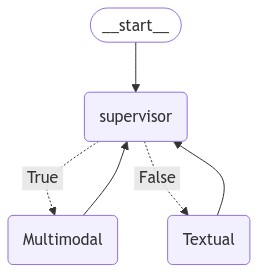

In [55]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [56]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(content="How to restore a building with water damaged ceiling")
        ],
        "media_files": "causes-of-structural-damage.jpg"
    }
)

for event in events:
    print(event)

{'supervisor': {'next': 'Multimodal'}}
{'Multimodal': {'messages': [HumanMessage(content="Restoring a building with a water-damaged ceiling involves several steps to ensure safety, structural integrity, and aesthetics. Here's a general guide to help you through the process:\n\n1. **Identify the Source of Water Damage:**\n   - Inspect the ceiling and roof for leaks, damaged pipes, or other sources of water intrusion.\n   - Repair the source of water to prevent further damage.\n\n2. **Safety Precautions:**\n   - Turn off electricity in the affected area to prevent electrical hazards.\n   - Wear protective gear such as gloves and masks to avoid exposure to mold or contaminants.\n\n3. **Assess the Damage:**\n   - Check for sagging, discoloration, or mold growth.\n   - Determine if the ceiling material is salvageable or needs replacement.\n\n4. **Dry the Affected Area:**\n   - Use fans, dehumidifiers, and ventilation to thoroughly dry the ceiling and surrounding areas.\n   - Ensure that all

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.